## Process Mining with Python: A Healthcare Application  
   
Within healthcare there are thousands of complex and variable processes that generate data including treatment of patients, lab results and internal logistic processes. Analysing this data is vital for improving these processes and ending bottlenecks.

In recent years, digitisation of healthcare records and systemetisation of healthcare processes has resulted in the generation of more and more data from complex healthcare processes. There has also been growing interest in using process mining techniques to optimise and debug processes to improve the quality and efficiency of care. Such techniques have been used to:
   
+ **Discover processes and characterise them in process models**.  
Different graphical languages such as petri nets, directly-follows graphs and business process models might be used to represent such models.
+ Discover bottlenecks and **identifying opportunities for improving efficiency** by analysing throughput and the time spent on each event.
+ **Determine to what extent real processes adhere to those in good practice** guidelines and treatment pathways.  

<br>
   
Data:
+ Data_ArtificialPatientTreatment.csv

---
Source:
+ [TU Eindhoven - Online Course "Process Mining in Healthcare"](https://www.futurelearn.com/courses/process-mining-healthcare)
+ [Medium - Process Mining with Python : A Healthcare Application](https://medium.com/@c3_62722/process-mining-with-python-tutorial-a-healthcare-application-part-1-ae02027a050)

+ [Eventlog Data@Gitlab](https://gitlab.com/healthcare2/process-mining-tutorial)  

---
30.03.2023 v1 dbe --- initial version for BINA FS23  
08.01.2024 v2 dbe --- minor corrections for CAS BPE16   

---

## Load Libraries and Data

In [1]:
import pandas as pd
import numpy as np
from datetime import date
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# a markdown formatted print output function printmd()
def printmd(string):
    display(Markdown(string))


In [3]:
%ls
%cd sample_data


sample_data/
/content/sample_data


In [4]:
fn = 'Data_ArtificialPatientTreatment.csv'
events = pd.read_csv(fn)

events.columns = ['patient', 'action', 'resource', 'datetime']
events['datetime'] = pd.to_datetime(events['datetime'])
events.head()


,patient,action,resource,datetime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09


In [5]:
print('{} has {} rows and {} columns.'.format(fn, events.shape[0], events.shape[1]))


Data_ArtificialPatientTreatment.csv has 690 rows and 4 columns.


## Some Feature Engineering

In [6]:
## Get the case start times to get the time deltas for the 'age' of each activity with respect to start
case_starts_ends = events.pivot_table(index='patient', aggfunc={'datetime': ['min', 'max']})
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['patient', 'caseend', 'casestart']
events = events.merge(case_starts_ends, on='patient')
events['relativetime'] = events['datetime'] - events['casestart']
events.head()

,patient,action,resource,datetime,caseend,casestart,relativetime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58


In [7]:
events['action'] = events['action'].apply(lambda x: x.strip())

In [8]:
delimiter = '___'

makeEventString = lambda x: delimiter.join(x)
makeEventString.__name__ = 'makeEventString'

numEvents = lambda x: len(x)
numEvents.__name__ = 'numEvents'


caselogs = events.pivot_table(index='patient', aggfunc={'action': [makeEventString, numEvents]})
caselogs = caselogs.reset_index()
caselogs.columns = ['patient', 'action_sequence', 'numactions']

events = pd.merge(events, caselogs, on='patient')
events['caselength'] = events['caseend'] - events['casestart']

events.head()


,patient,action,resource,datetime,caseend,casestart,relativetime,action_sequence,numactions,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,First consult___Blood test___Physical test___S...,6,6 days 20:49:17


In [9]:
## Get day of week
events['weekday'] = events['datetime'].apply(lambda x: x.weekday())
events['date'] = events['datetime'].apply(lambda x: x.date())
events['startdate'] = events['casestart'].apply(lambda x: x.date())
events['hour'] = events['datetime'].apply(lambda x: x.time().hour)
## Get relative times in more friendly terms
events['relativetime_s'] = events['relativetime'].dt.seconds + 86400*events['relativetime'].dt.days
events['relativedays'] = events['relativetime'].dt.days



In [10]:
events.head()

,patient,action,resource,datetime,caseend,casestart,relativetime,action_sequence,numactions,caselength,weekday,date,startdate,hour,relativetime_s,relativedays
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,11,0,0
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,12,4042,0
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,12,4419,0
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,16,16855,0
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,3,2017-01-05,2017-01-02,13,265378,3


## Typical Questions

### a) What is the minimum number of events per case?

In [11]:
printmd('**Minimum number of events per case**: {}'.format(min(events['patient'].value_counts())))

**Minimum number of events per case**: 6



```
# Als Code formatiert
```

### b) Patient #26 consulations?
Which doctor did s/he have his/her consultation with?


In [15]:
xpat = 'patient 26'
first_doctor = events[events['datetime']==min(events[events['patient']==xpat]['datetime'])]['resource'].values[0]
last_doctor = events[events['datetime']==max(events[events['patient']==xpat]['datetime'])]['resource'].values[0]
printmd('**First doctor**: {}'.format(first_doctor))
printmd('**Last doctor**: {}'.format(last_doctor))


**First doctor**:  Dr. Bob

**Last doctor**:  Dr. Ben

### c) Which activity has the lowest occurrence overall in the event log?

In [16]:
printmd('**Activity with lowest occurrence**: {}'.format(events['action'].value_counts().sort_values().idxmin()))

**Activity with lowest occurrence**: Surgery

# Visualisations

In [17]:
activities = list(events['action'].unique())
markers = ['*', '+', 'h', 'o', 'x', 'D', '^', 'v']
assert(len(activities)==len(markers))


In [19]:
patients = events['patient'].unique()
# select first 50 patients
selected_patients = patients[0:50]
patientX = events[events['patient'].isin(selected_patients)]



### a) Discrete event plot
* y-axis represents each patient case.
* x-axis represents time since case was initiated.
* Different marker shapes represent different types of cases.

In [20]:
## Widget libraries
from ipywidgets import widgets
from ipywidgets import interact, interact_manual

patients = events['patient'].unique()

@interact
def getCaseData(x=patients):
    return events[events['patient']==x]



interactive(children=(Dropdown(description='x', options=('patient 0', 'patient 1', 'patient 2', 'patient 3', '…

In [21]:
patientX = getCaseData(patients[10])

### b) Most frequent event sequence

In [22]:
most_frequent_event = events['action_sequence'].value_counts().idxmax()


printmd('**The most frequent event (sequence) has** {} **activities.**'.format(len(most_frequent_event.split(delimiter))))
printmd('**The activity sequence is**:  {}.'.format(', '.join(most_frequent_event.split(delimiter))))

**The most frequent event (sequence) has** 7 **activities.**

**The activity sequence is**:  First consult, Blood test, X-ray scan, Physical test, Second consult, Medicine, Final consult.

## Filtering events

### Removing events that all patients share

**The following actions are common to all cases**: Blood test, Final consult, First consult, Physical test, Second consult

**The following actions are the ones that we wish to keep (not common to all cases)**: Medicine, Surgery, X-ray scan

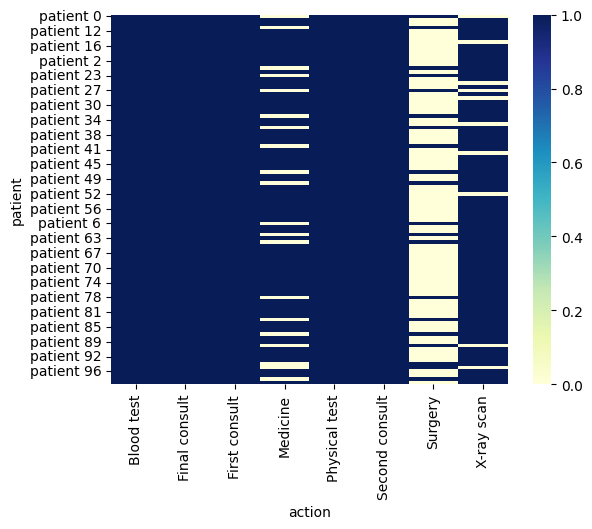

In [23]:
## Visualise which events are common to patients
patient_events = pd.crosstab(events['patient'], events['action'])
sns.heatmap(patient_events, cmap="YlGnBu")

nunique = patient_events.apply(pd.Series.nunique)
shared_actions = nunique[nunique==1].index
actions_to_keep = nunique[nunique>1].index
printmd('**The following actions are common to all cases**: {}'.format(', '.join(shared_actions)))
printmd('**The following actions are the ones that we wish to keep (not common to all cases)**: {}'.format(', '.join(actions_to_keep)))


## Process Mining
* Check out this [introduction to process mining in Python](https://towardsdatascience.com/introduction-to-process-mining-5f4ce985b7e5).
* [Documentation for pm4py](https://pm4py.fit.fraunhofer.de/)

In [24]:
!pip install pm4py
import pm4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26095 sha256=12d1f2c3bb56c0845c50e705a60039e6b27d5b0a4211a8ecd0663d527e3e953e
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
  Created wheel for stringdist: filename=StringDist-1.0.9-cp310-cp310-linux_x86_64.whl size=16967 sha256=6d2351ba2582bbb34f22c2acba65c1334db0233021a5cf816e5039c9a01043a1
  Stored in directory: /root/.cache/pip/wheels/79/25/0a/4a0c2c7af31a8b473f6e10e30312396f31ae899722600d7b99
Successfully built intervaltree stringdist


In [25]:
pip --version

pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


In [26]:
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

# viz
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.petri_net.util import performance_map
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# misc
from pm4py.objects.conversion.process_tree import converter as pt_converter


In [27]:
eventlog = events.copy()
### Specify which columns correspond to case (case:concept:name),
###event (concept:name) and timestamp (time:timestamp) - rename columns in accordance
###with pm4py

eventlog.rename(columns={'datetime': 'time:timestamp', 'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)

## Convert to log format
log = log_converter.apply(eventlog)


### Alpha miner

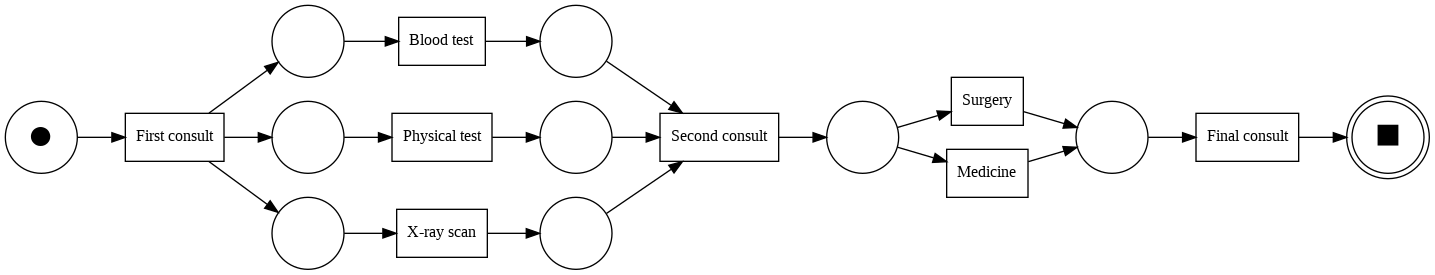

In [28]:
# alpha miner
net, initial_marking, final_marking = alpha_miner.apply(log)

# Visualise
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

In [34]:
# add information about frequency to the viz
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=log)

# save the Petri net
pn_visualizer.save(gviz, "Plot_AlphaMiner_Healthcare_Petrinet.png")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

''

### Directly-follows graph

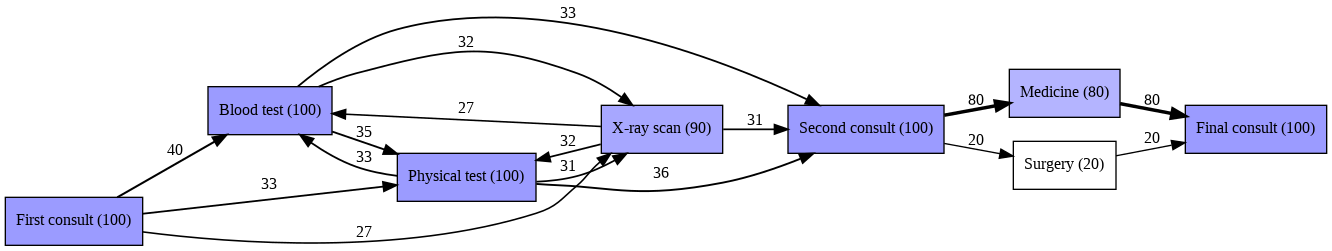

In [30]:
#Create graph from log
dfg = dfg_discovery.apply(log)

# viz
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

With average times between nodes (performance)

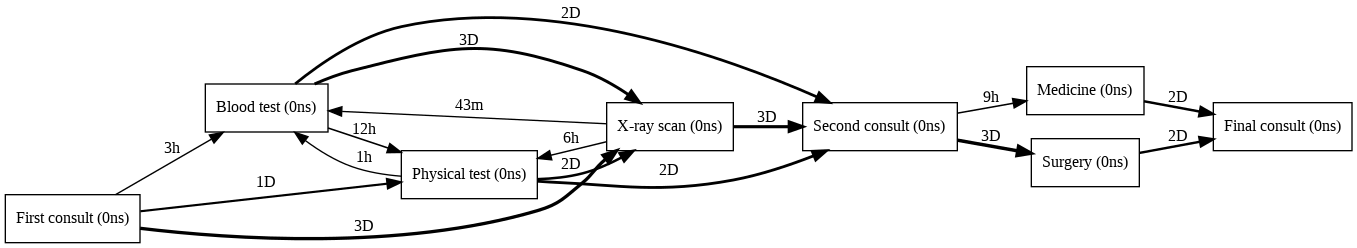

In [31]:
# creatig the graph from log
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)

# viz
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)

### Heuristic miner

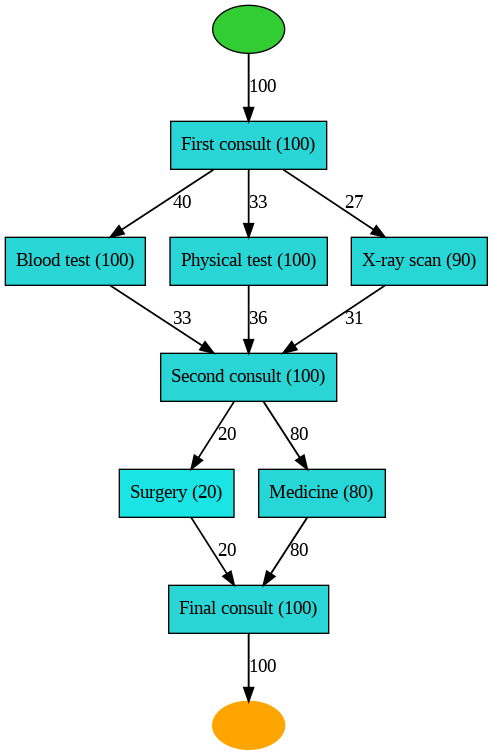

In [32]:
# heuristics miner
heu_net = heuristics_miner.apply_heu(log)

# viz
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

Petri-net of heuristic miner output

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

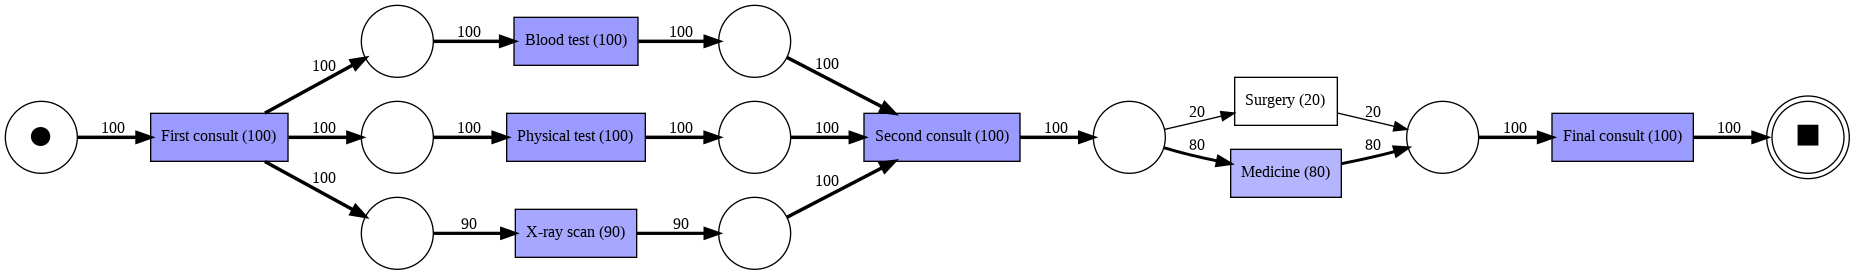

In [33]:
# heuristics miner
net, im, fm = heuristics_miner.apply(log)

# viz
gviz = pn_visualizer.apply(net, im, fm)
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=log)
#pn_visualizer.view(gviz)
pn_visualizer.view(gviz)